In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the dataset
dataset_path = "/content/drive/MyDrive/Research/NLP/Project/Identifying_offensive_text_with_Bengla_language_from_social_media.xlsx"
df = pd.read_excel(dataset_path)

length_yes = len(df[df.threat_label=='yes'])
length_no =len(df[df.threat_label=='no'])
print(length_yes, length_no)

947 3976


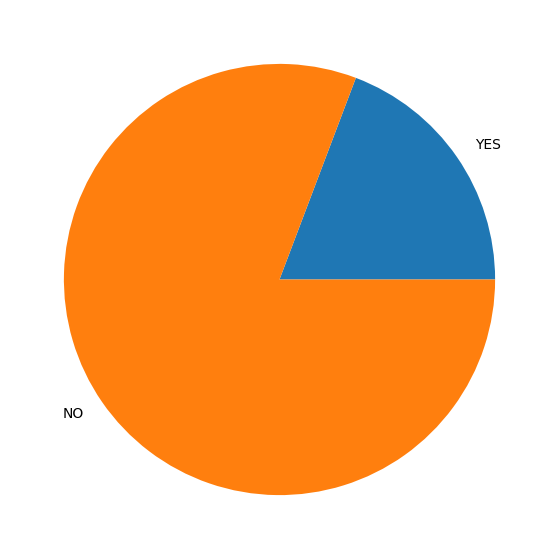

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


stas = ['YES', 'NO']

data = [length_yes, length_no]

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = stas)


plt.show()

In [ ]:
df.dtypes

comment         object
Category        object
threat_label    object
label           object
dtype: object

In [ ]:
df.shape

(4923, 4)

In [ ]:
df.columns

Index(['comment', 'Category', 'threat_label', 'label'], dtype='object')

In [ ]:
df['Category'].unique()

array(['Actor', 'Singer', 'Sports', 'Politician', 'Social', 'actor',
       'politician', 'sports', 'social', 'singer'], dtype=object)

In [ ]:
df['threat_label'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
df['label'].unique()

array(['troll', 'not bully', 'religious', 'sexual', 'threat'],
      dtype=object)

In [ ]:
wrong_lable = df.loc[df['threat_label'] == 'Male']
print(wrong_lable)

Empty DataFrame
Columns: [comment, Category, threat_label, label]
Index: []


In [ ]:
null_mask = df.isnull().any(axis=1)
null_rows = null_mask.to_numpy().nonzero()[0]
# the reason is to add 2 is first of all it start counting to get the index value form 0 and there is a column level with is not need
print(null_rows+2)

[]


In [ ]:
df.isnull().sum()

comment         0
Category        0
threat_label    0
label           0
dtype: int64

In [ ]:
import warnings
warnings.filterwarnings("ignore",
    "Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access", 
    UserWarning)

df.threat_label = df.threat_label.replace({'yes': 1, 'no': 0})

In [ ]:
df = df.drop('Category', axis=1)
df = df.drop('label', axis=1)

In [ ]:
df.head(5)

,comment,threat_label
0,তোমার বিশ্বাসের সাথে আমাদের কোন যায় আসেনা।তুমি...,0
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছিলেন,0
2,অরে বাবা এই টা কোন পাগল,0
3,ক্যাপ্টেন অফ বাংলাদেশ,0
4,পটকা মাছ,0


In [ ]:
df['threat_label'] = pd.to_numeric(df['threat_label'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4923 entries, 0 to 4922
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment       4923 non-null   object
 1   threat_label  4923 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 77.0+ KB


In [ ]:
df.head(5)

,comment,threat_label
0,তোমার বিশ্বাসের সাথে আমাদের কোন যায় আসেনা।তুমি...,0
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছিলেন,0
2,অরে বাবা এই টা কোন পাগল,0
3,ক্যাপ্টেন অফ বাংলাদেশ,0
4,পটকা মাছ,0


In [ ]:
# Get the maximum length of text in the 'text_column' column
max_length = df['comment'].str.len().max()

print('Maximum text length:', max_length)

Maximum text length: 1296


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random
import time

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased', truncation=True)

class BanglaNewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.comment
        self.targets = self.data.threat_label
        self.max_length = max_length
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        labels = self.targets[index]
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_tensors='pt'
            
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        
        return ids.squeeze(), mask.squeeze(), token_type_ids.squeeze(), labels

max_length = 256
batch_size = 16


In [ ]:
train_data, test_data = train_test_split(df, test_size=0.10, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.20, random_state=42)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_dataset = BanglaNewsDataset(train_data, tokenizer, max_length)
val_dataset = BanglaNewsDataset(val_data, tokenizer, max_length)
test_dataset = BanglaNewsDataset(test_data, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import transformers
transformers.logging.set_verbosity_error()



train_losses = []
val_lossess = []
train_accus = []
val_accus = []

# Set random seeds for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=2)



# Set batch size and number of workers for data loader
batch_size = 32
num_workers = 2

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the number of epochs and start training
num_epochs = 5
for epoch in range(num_epochs):
    # Train the model
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        input_ids = data[0].to(device)
        attention_mask = data[1].to(device)
        labels = data[3].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics every epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f'Train Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%')
    train_losses.append(epoch_loss)
    train_accus.append(epoch_acc)
    
    # Evaluate the model on the validation set
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            # Get the inputs and labels
            input_ids = data[0].to(device)
            attention_mask = data[1].to(device)
            labels = data[3].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)[0]
            loss = criterion(outputs, labels)

            # Compute statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Print statistics every epoch
    v_epoch_loss = running_loss / len(val_loader)
    v_epoch_acc = 100 * correct / total
    print(f'Valid Epoch {epoch+1}/{num_epochs} - Loss: {v_epoch_loss:.4f} - Accuracy: {v_epoch_acc:.2f}%')
    val_lossess.append(v_epoch_loss)
    val_accus.append(v_epoch_acc)

Train Epoch 1/5 - Loss: 0.4709 - Accuracy: 79.98%
Valid Epoch 1/5 - Loss: 0.3813 - Accuracy: 82.73%
Train Epoch 2/5 - Loss: 0.3712 - Accuracy: 84.05%
Valid Epoch 2/5 - Loss: 0.3776 - Accuracy: 82.16%
Train Epoch 3/5 - Loss: 0.3019 - Accuracy: 87.44%
Valid Epoch 3/5 - Loss: 0.3925 - Accuracy: 84.09%
Train Epoch 4/5 - Loss: 0.2162 - Accuracy: 91.20%
Valid Epoch 4/5 - Loss: 0.5222 - Accuracy: 82.16%
Train Epoch 5/5 - Loss: 0.1544 - Accuracy: 94.29%
Valid Epoch 5/5 - Loss: 0.7004 - Accuracy: 82.73%


# Evaluation Graph

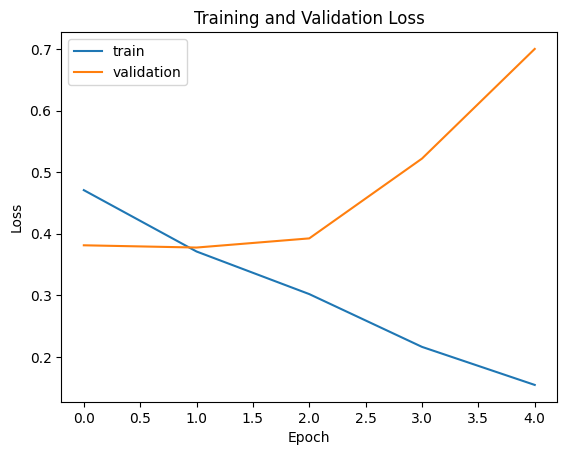

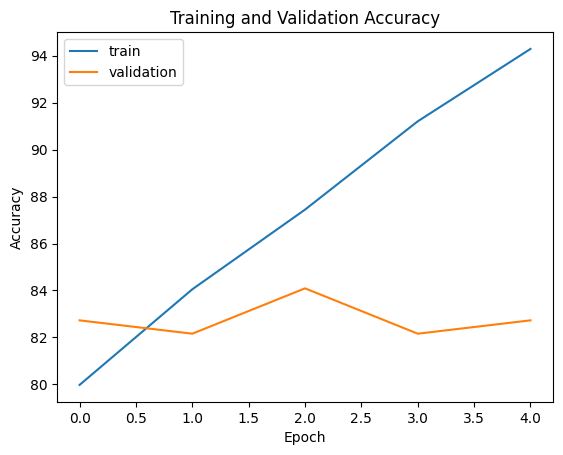

In [ ]:
import matplotlib.pyplot as plt
  
# Plot the loss curve
plt.plot(train_losses, label='train')
plt.plot(val_lossess, label='validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(train_accus, label='train')
plt.plot(val_accus, label='validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Matrix Calculation

In [ ]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        input_ids, attention_mask, token_type_ids, labels = [t.to(device) for t in data]
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


from sklearn.metrics import classification_report

# Convert the label lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Print the classification report
target_names = [' Yes', 'No']  
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         Yes       0.88      0.95      0.91       397
          No       0.62      0.36      0.46        83

    accuracy                           0.85       480
   macro avg       0.75      0.66      0.69       480
weighted avg       0.83      0.85      0.84       480



In [ ]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[379  18]
 [ 53  30]]


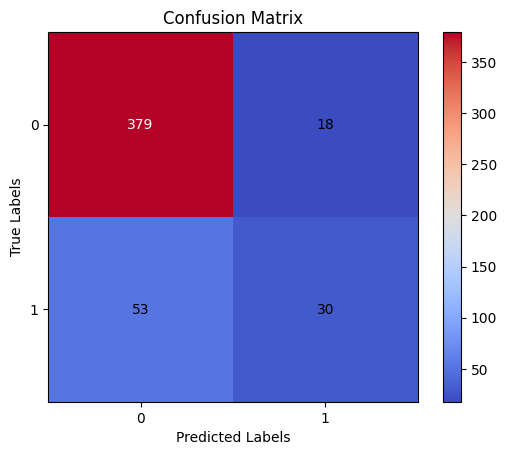

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, cmap='coolwarm')

# Add axis labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add color bar
plt.colorbar()

# Add tick marks for each label
tick_marks = np.arange(len(set(y_true)))
plt.xticks(tick_marks, sorted(set(y_true)))
plt.yticks(tick_marks, sorted(set(y_true)))

# Add text annotations for each cell
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.7958
Precision: 0.8194
Recall: 0.7958
F1-score: 0.8055


# Preparing Model for real-life testing

In [ ]:
torch.save(model.state_dict(), "distilbert-base-multilingual-cased.pth")

In [ ]:
import transformers
transformers.logging.set_verbosity_error()


import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
# Load the tokenizer and model architecture
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased')

# Load the saved weights into the model
model.load_state_dict(torch.load("distilbert-base-multilingual-cased.pth"))

# Prepare input text data
input_text = str(input()) # বাংলাদেশ একটি সুন্দর দেশ।
input_ids = tokenizer.encode(input_text, add_special_tokens=True)
input_ids = torch.tensor(input_ids).unsqueeze(0)  # Batch size 1

# Make prediction
outputs = model(input_ids)
predicted_class = torch.argmax(outputs[0]).item()


if predicted_class == 1:
  print("This sentence is threatful!!!")
else:
  print("This sentence is not threatful...!")


বাংলাদেশ একটি সুন্দর দেশ।
This sentence is not threatful...!
